# Lecture 12 Demo: Bootstrap

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error


plt.style.use("fivethirtyeight")

## Central Limit Theorem

Let $x_1, \ldots, x_n$ be i.i.d. random variables that have mean $\mu$ and finite variance $\sigma^2$. Let $\bar{x}_n = \frac{1}{n}\sum_i x_i$ be the mean of these random variables.

Then **regardless of the distribution $p(x_i)$**, the distribution of $\bar{x}_n$ will converge to a normal distribution with mean $\mu$ and variance $\frac{\sigma^2}{n}$.

Practically, this means for large enough $n$, we can treat the sample mean as a normally distributed random variable with mean $\mu$ and variance $\sigma^2/n$.



### CLT for Maximum Likelihood

A similar result holds for the maximum likelihood estimate:
* Suppose we're trying to estimate a parameter $\theta$ from a sample of $n$ data points, and we use maximum likelihood estimation to obtain $\hat{\theta}_{MLE}$. 
* Then, the distribution of $\hat{\theta}_{MLE}$ converges to a normal distribution with mean $\theta$ (the true parameter) and variance $\frac{1}{nI(\theta)}$. 

$I(\theta)$ is the Fisher information of the model: details are beyond the scope of this class, but intuitively, it depends on the likelihood model and answers the question "how much information do our data give us about the parameter $\theta$?"

## Quantifying Uncertainty in Frequentist Models

For many models, we can analytically compute the distribution of our estimate. In other cases (or even if we can compute it analytically), we can use the bootstrap to approximate the sampling distribution. Here's how it works:

In [2]:
def bootstrap_1d(original_samples, B=1000, fnc=np.mean):
    """
    Computes many bootstrap iterations of the specified function
    on the provided samples.
    """
    theta_boot = np.zeros(shape=(B,))
    n = len(original_samples)
    for b in range(B):
        bootstrap_samples = np.random.choice(original_samples, n)
        theta_boot[b] = fnc(bootstrap_samples)
        
    return theta_boot

## Bootstrap for 1D distributions

### Bootstrap distribution of sample mean

In [3]:

def show_sample_estimate_dist(mu, sigma, N, fnc=np.mean):
    """
    Shows the distribution of the estimated statistic
    on normally distributed data with the specified parameters.
    """
    samples = np.random.normal(mu, sigma, N)

    X_grid = np.linspace(-1.5,1.5,100)

    mu_boot = bootstrap_1d(samples, fnc=fnc)

    plt.figure(figsize=(10,6))
    sns.histplot(mu_boot, label="Bootstrap distribution", stat='density', kde=True)
    if fnc == np.mean:
        normal_pdf = stats.norm.pdf(X_grid, loc=mu, scale=sigma/np.sqrt(N))
        plt.plot(
            X_grid, normal_pdf, linestyle='--', color='tab:red',
            label="True distribution of sample mean"
        )
    else:
        true_samples = simulate_from_true(N, mu, sigma, fnc=fnc)
        sns.kdeplot(
            x=true_samples, color='tab:red', 
            label=f'True (theoretical) distribution of sample {fnc.__name__}'
        )

    plt.title(f"Distribution of sample {fnc.__name__}, N={N}")
    plt.annotate(
        r"Est. stdev from bootstrap: "
        f"{np.std(mu_boot):.3f}", 
        (0.1, 0.6),
        xycoords="figure fraction"
    )

    plt.annotate(
        r"True stdev ($\sigma/\sqrt{N}$): "
        f"{sigma / np.sqrt(N):.3f}", 
        (0.1, 0.65),
        xycoords="figure fraction"
    )
    plt.legend()


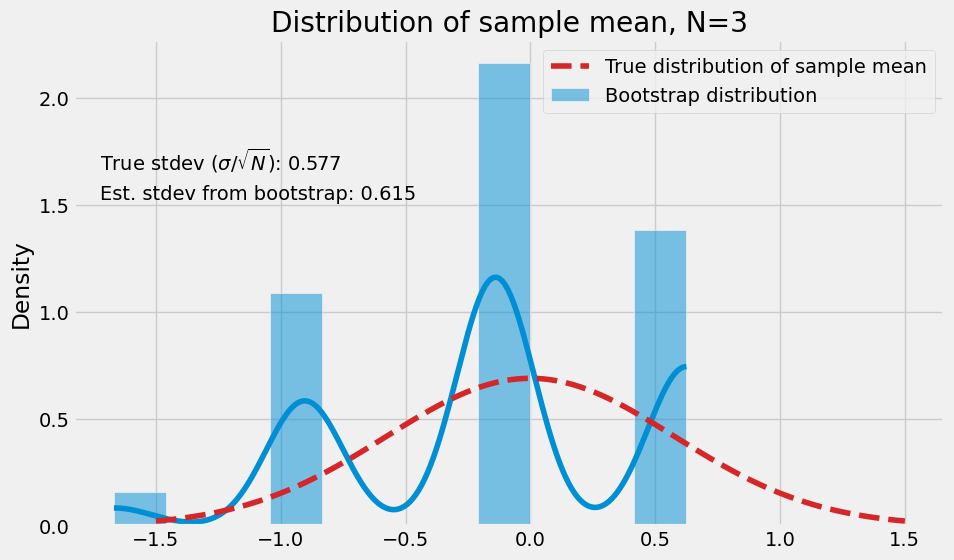

In [4]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=3, fnc=np.mean)

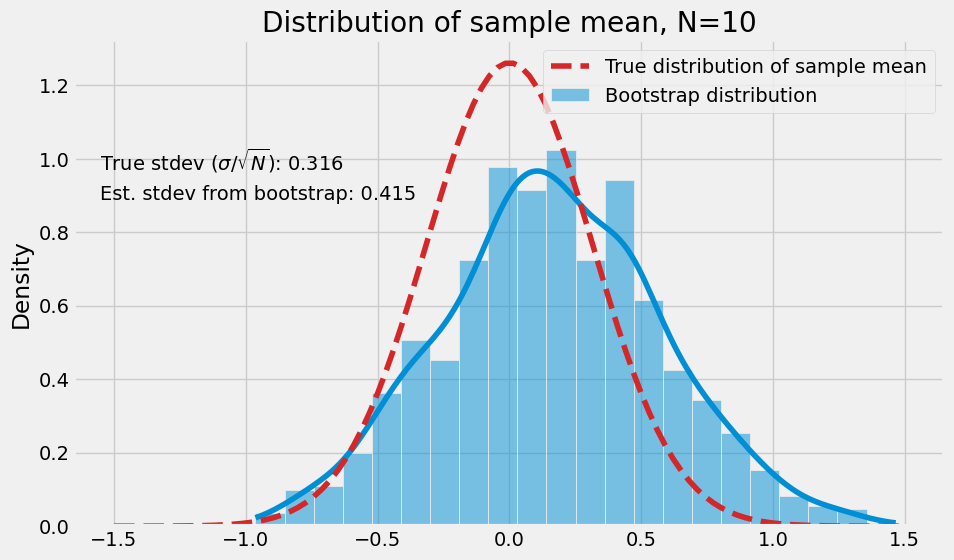

In [5]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=10, fnc=np.mean)

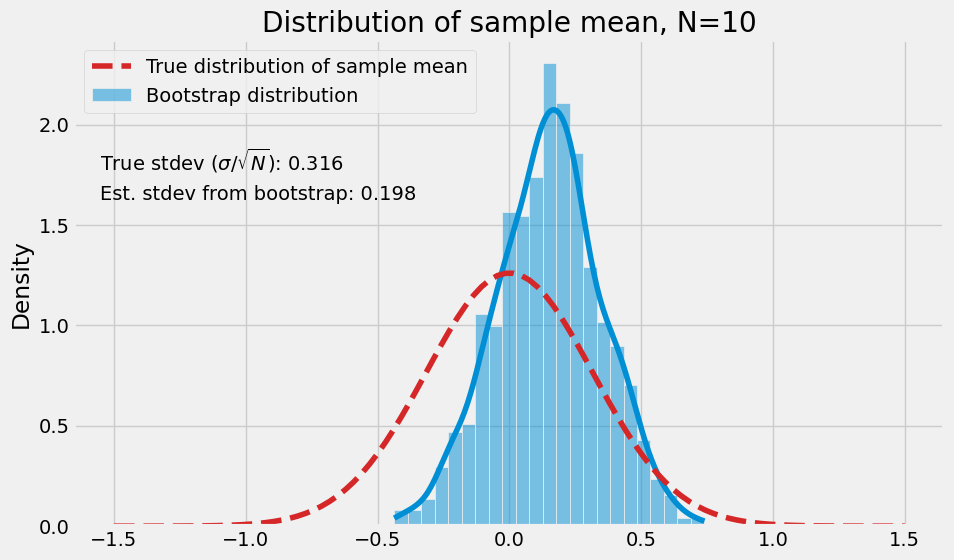

In [6]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=10, fnc=np.mean)

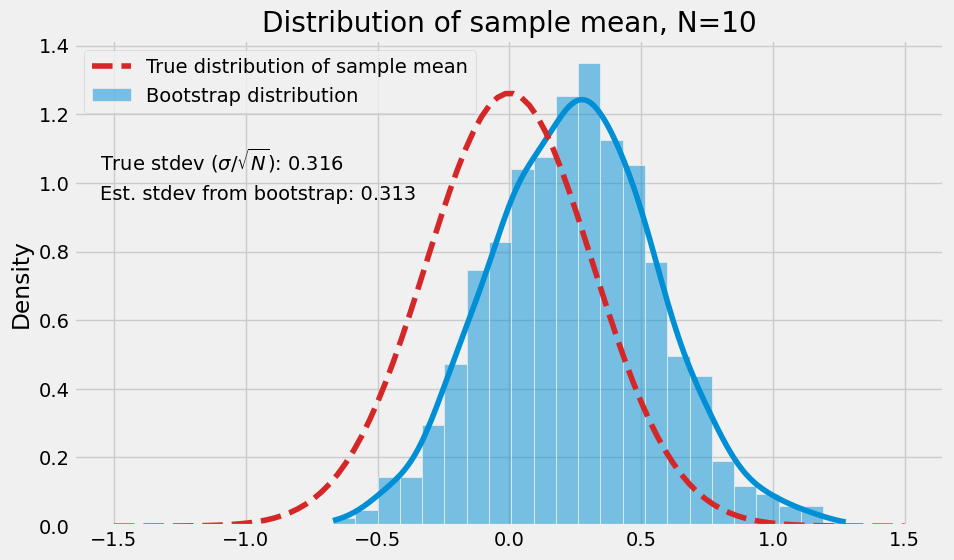

In [7]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=10, fnc=np.mean)

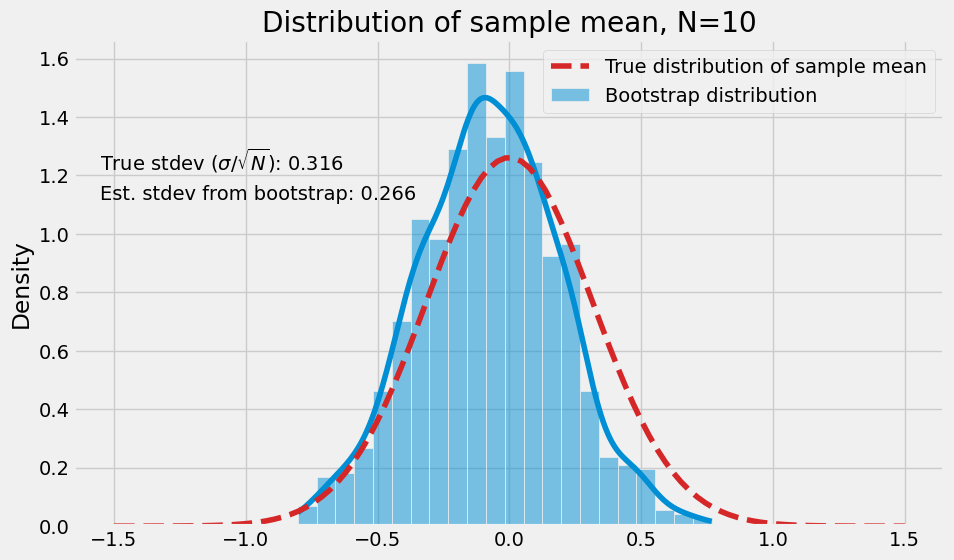

In [8]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=10, fnc=np.mean)

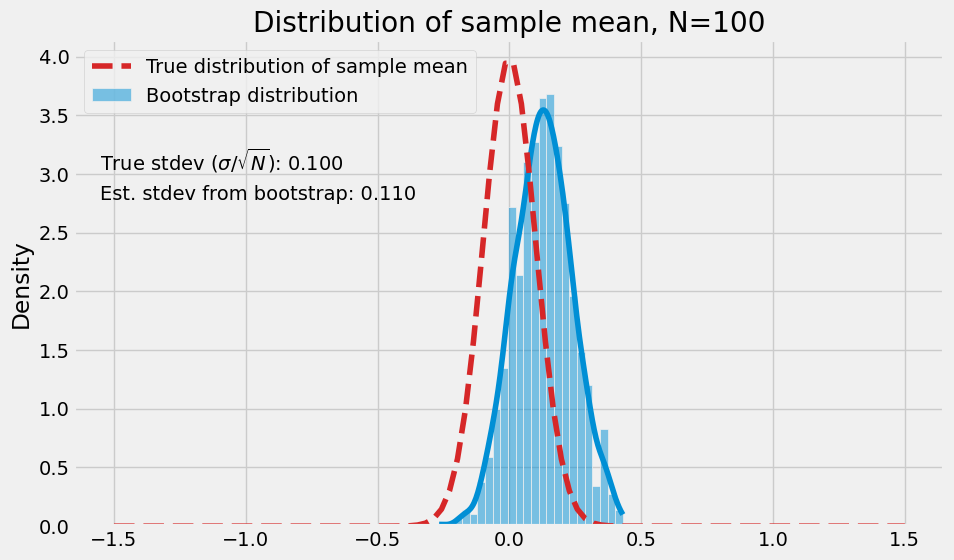

In [9]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=100, fnc=np.mean)

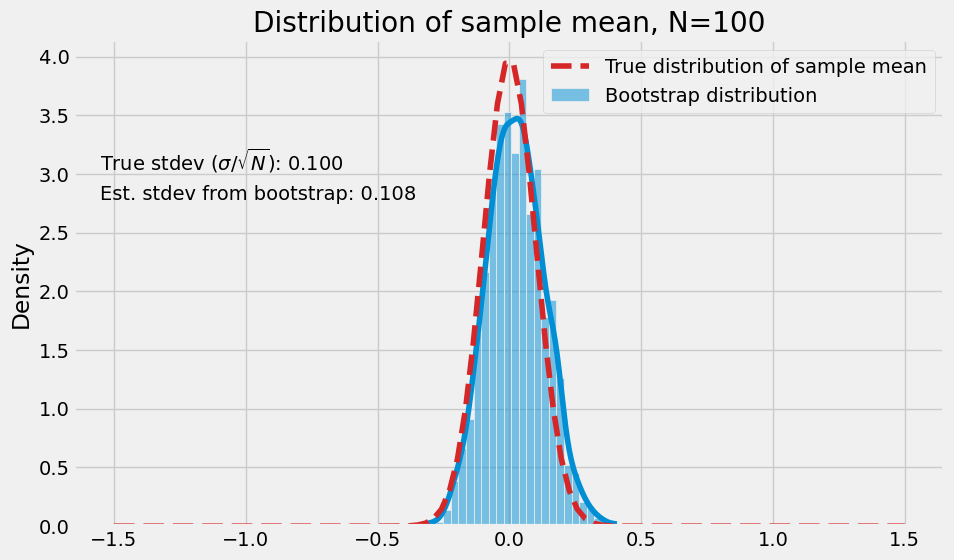

In [10]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=100, fnc=np.mean)

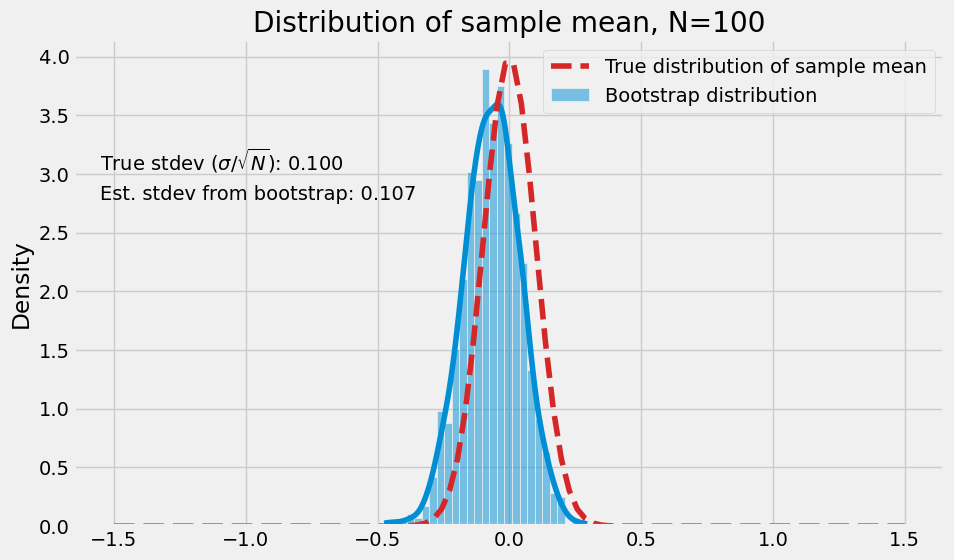

In [11]:
show_sample_estimate_dist(mu=0, sigma=1.0, N=100, fnc=np.mean)

Becomes better approximation as the sample size $N$ increases, but $N=10$ is already surprisingly good.

In [12]:
N_vals = (np.arange(10)+1) * 10
reps = 20
mu = 0
sigma = 1
error_in_mean = []
error_in_sd = []
for N in N_vals:
    true_mean = np.ones(reps) * mu
    est_mean = np.zeros(reps)
    true_std = sigma / np.sqrt(N) * np.ones(reps)
    est_std = np.zeros(reps)
    for i in range(reps):
        samples = np.random.normal(mu, sigma, N)
        est_mean[i] = np.mean(samples)
        mu_boot = bootstrap_1d(samples, fnc=np.mean)
        est_std[i] = np.std(mu_boot)
    error_in_mean.append(mean_squared_error(true_mean, est_mean))
    error_in_sd.append(mean_squared_error(true_std, est_std))

In [13]:
N_vals

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

Text(0.5, 1.0, 'Error in estimating sd vs mean')

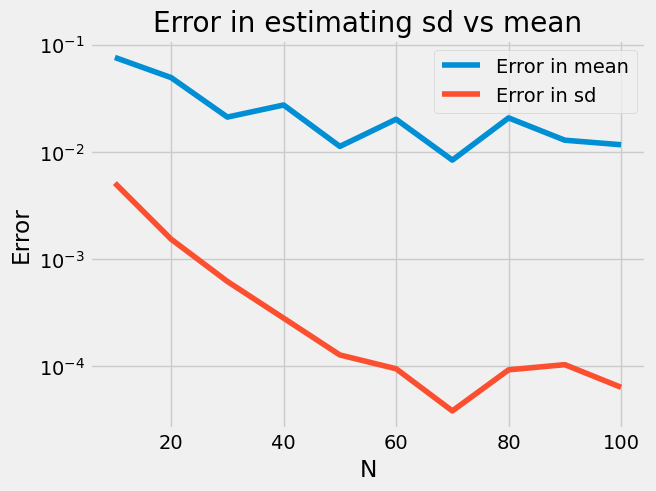

In [14]:
plt.plot(N_vals, error_in_mean, label="Error in mean")
plt.plot(N_vals, error_in_sd, label="Error in sd")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()
plt.semilogy()
plt.title("Error in estimating sd vs mean")


### 1.3 Bootstrap distribution of sample mean, median and 90th percentile

In [15]:
def simulate_from_true(N, mu, sigma, K=5000, fnc=np.mean):
    """Generates K samples from the true distribution (not bootstrap) for comparison"""
    theta_hat = np.zeros(shape=(K,))
    for k in range(K):
        samples = np.random.normal(mu, sigma, N)
        theta_hat[k] = fnc(samples)
        
    return theta_hat

In [16]:
def compare_mean_median_90pctile(mu, sigma, N):
    """Evaluate bootstrap for mean, median, and 90th percentile"""
    samples = np.random.normal(mu, sigma, N)

    fig, ax = plt.subplots(1,3, figsize = (20,6))

    # Sample mean
    X_grid = np.linspace(-1.5,1.5,100)
    mu_boot = bootstrap_1d(samples, fnc=np.mean)
    mu_hat = simulate_from_true(N, mu, sigma, fnc=np.mean)


    sns.histplot(x=mu_boot, label="Bootstrap distribution", ax=ax[0], stat='density', kde=True)
    ax[0].plot(X_grid, stats.norm.pdf(X_grid, loc=mu, scale=sigma/np.sqrt(N)), color='tab:red',
             label="Theoretical distribution")
    ax[0].set_title(f"Sample mean (N={N})")
    ax[0].legend()

    # Sample median
    X_grid = np.linspace(-1.5,1.5,100)
    med_boot = bootstrap_1d(samples, fnc=np.median)
    med_hat = simulate_from_true(N, mu, sigma, fnc=np.median)

    sns.histplot(x=med_boot, label="Bootstrap distribution", ax=ax[1], stat='density', kde=True)
    sns.kdeplot(x=med_hat, label="Theoretical distribution", ax=ax[1], color='tab:red')
    ax[1].set_title(f"Sample median (N={N})")

    # Sample 90th percentile
    X_grid = np.linspace(0,4,100)
    perc90_fnc = lambda x : np.quantile(x, 0.9)
    perc90_boot = bootstrap_1d(samples, fnc=perc90_fnc)
    perc90_hat = simulate_from_true(N, mu, sigma, fnc=perc90_fnc)

    sns.histplot(x=perc90_boot, label="Bootstrap distribution", ax=ax[2], stat='density', kde=True)
    sns.kdeplot(x=perc90_hat, label="Theoretical distribution", ax=ax[2], color='tab:red')
    ax[2].set_title(f"Sample 90th percentile (N={N})")



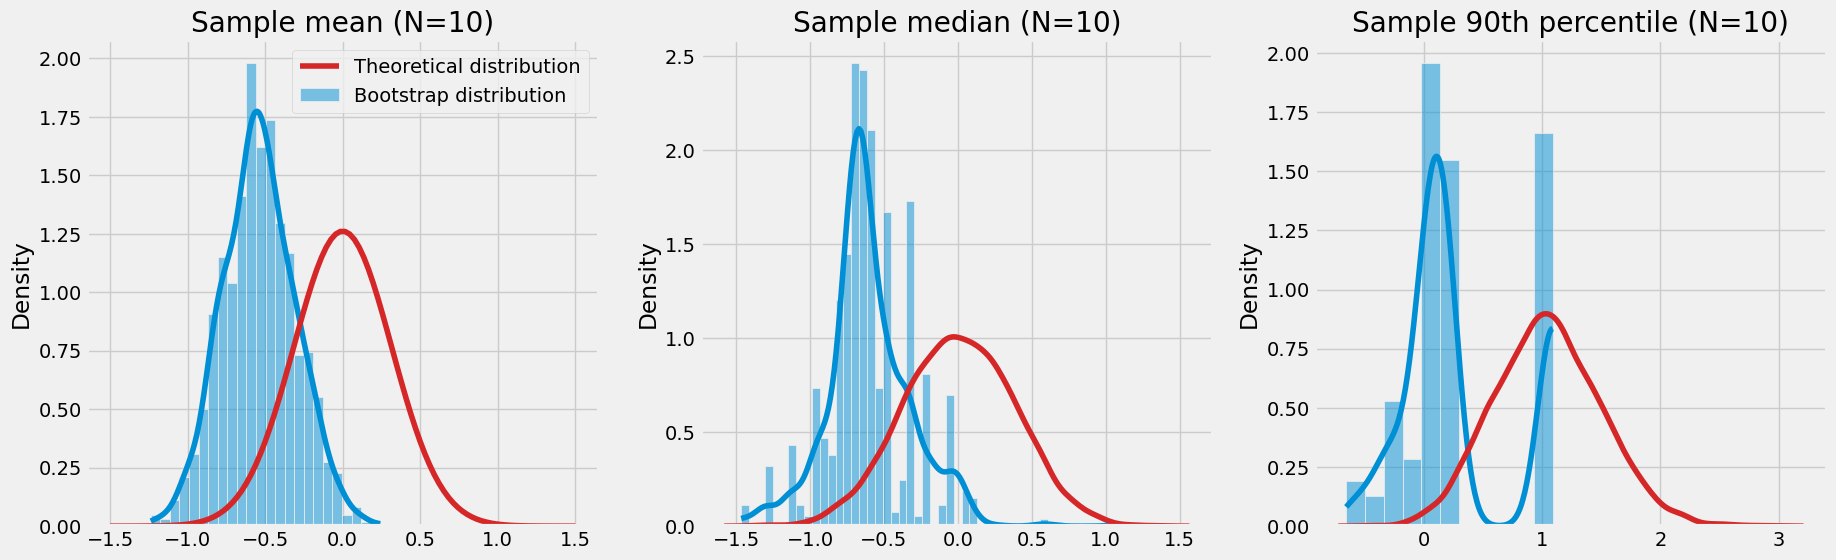

In [17]:
compare_mean_median_90pctile(mu=0, sigma=1, N=10)

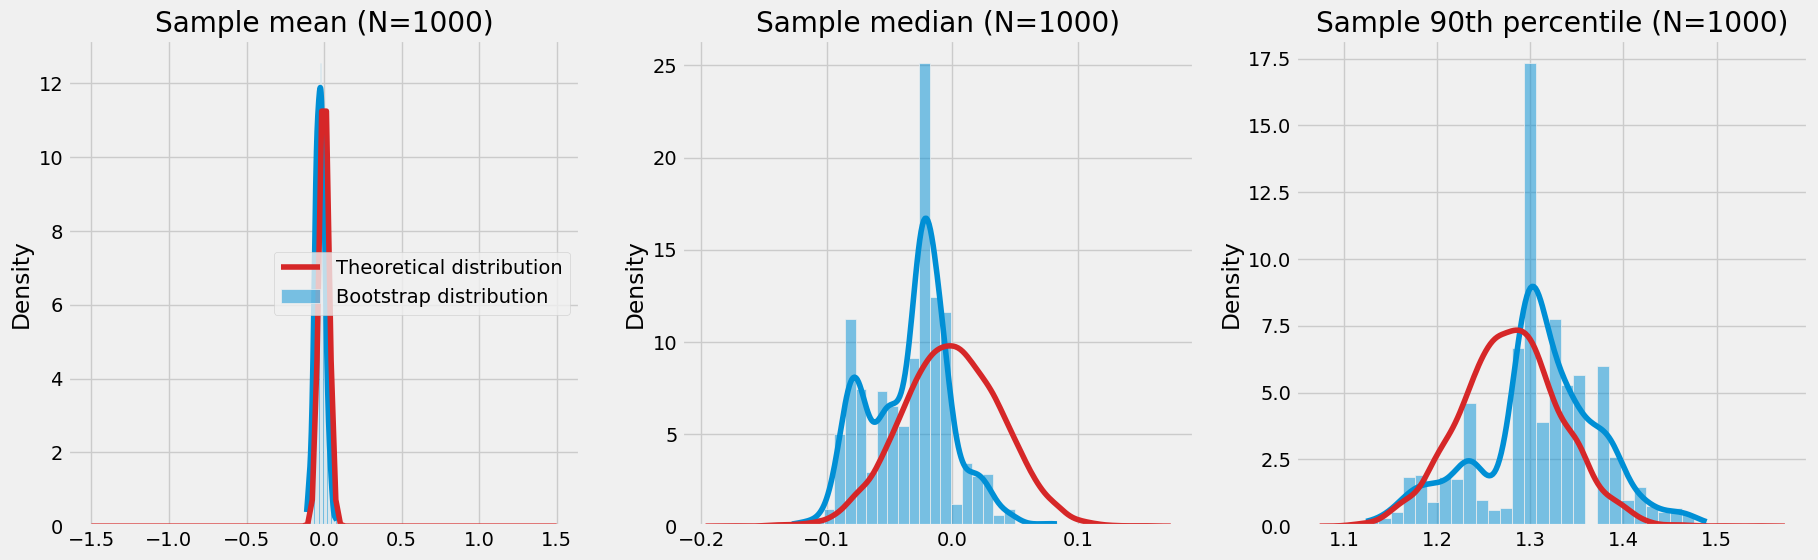

In [18]:
compare_mean_median_90pctile(mu=0, sigma=1, N=1000)

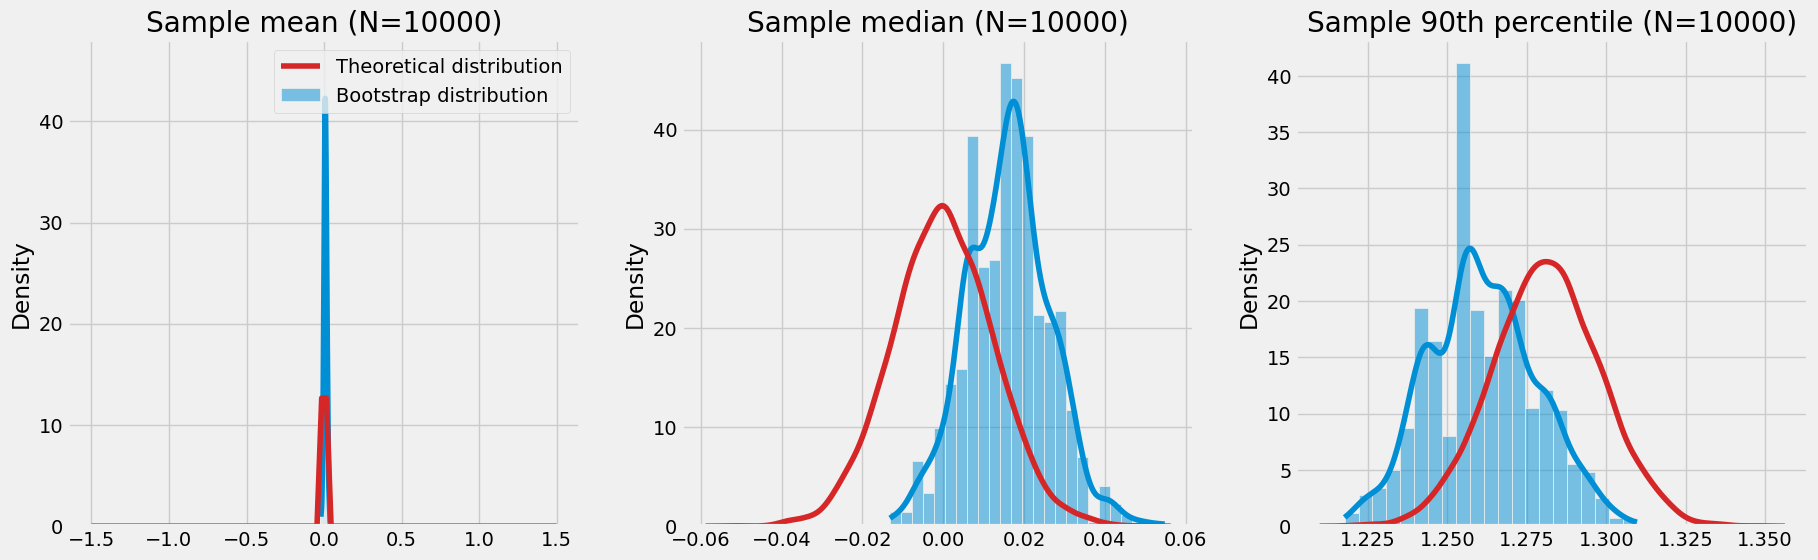

In [19]:
compare_mean_median_90pctile(mu=0, sigma=1, N=10000)

Median and 90th percentile requires more samples in order to give good approximations.

### 1.4 Bootstrap distribution of sample max

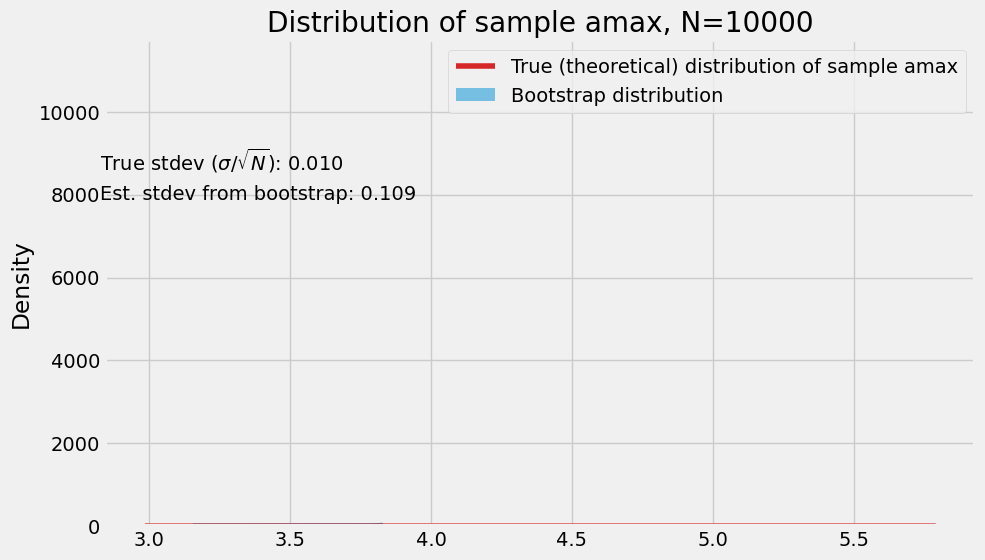

In [20]:
N = 2000
show_sample_estimate_dist(mu=0, sigma=1, N=10000, fnc=np.max)

### Generating confidence intervals from bootstrap

In [21]:
samples = np.random.normal(0, 1, 100)
mu_boot = bootstrap_1d(samples, fnc=np.mean)


In [22]:
mu_boot

array([ 1.02805762e-01, -4.34477111e-02, -1.26385531e-01, -7.99904154e-02,
       -8.32745872e-02, -1.23518455e-01, -1.70909960e-01,  1.14743141e-01,
       -1.44930258e-01, -8.98506740e-04, -5.79475314e-02,  8.23541372e-02,
        2.36282327e-03, -9.88036052e-02, -7.16983386e-02, -1.45888199e-01,
       -1.44669269e-01,  3.49574439e-02,  9.84167791e-03, -3.83040005e-02,
       -2.20099853e-01,  1.30458503e-01, -2.31447636e-01, -8.08964179e-03,
       -7.58708454e-02, -5.73603317e-02, -8.05039035e-02, -8.18835525e-03,
       -1.25496781e-03, -2.68951491e-01, -2.26752539e-02, -1.86470266e-01,
       -9.04419063e-02, -1.68099984e-02,  6.75758421e-02,  2.07105118e-01,
       -5.27349021e-02, -3.83402592e-03, -2.40150148e-01, -9.89434607e-02,
        3.45373605e-02, -1.31063316e-01, -1.12963642e-02, -1.78961101e-01,
       -1.60385803e-02, -1.30841859e-01, -1.32313850e-01, -2.52609317e-01,
        7.73593854e-03, -8.26756046e-02, -3.16749303e-01, -1.61312446e-01,
        7.71231386e-02,  

In [23]:
# 90% confidence interval
lower = np.percentile(mu_boot, 5)
upper = np.percentile(mu_boot, 95)
sample_mean = np.mean(samples)
print(f'Estimate of the mean: {sample_mean:0.3f}')
print(f'90% confidence interval: ({lower:0.3f}, {upper:0.3f})')


Estimate of the mean: -0.060
90% confidence interval: (-0.211, 0.098)


## 2. Bootstrap for GLM

In [24]:
def bootstrap_xy(X, y, fnc, original_estimate=None, B=1000, plot=True):
    """
    Uses bootstrap to generate multiple samples for estimates
    of the provided function.
    """
    d = X.shape[1]
    N = X.shape[0]
    w_hat = fnc(X, y)
    w_boot = np.zeros(shape=(B,d))
    for b in range(B):
        # we need to choose x-y pairs, so start by picking indices
        bootstrap_indices = np.random.choice(np.arange(N), N)
        # then, use those indices to create a bootstrap sample
        bootstrap_X = X.iloc[bootstrap_indices, :]
        bootstrap_y = y.iloc[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    if plot:
        plt.scatter(w_boot[:,0], w_boot[:,1], c='b')
        plt.scatter(w_hat[0], w_hat[1], c='r', marker='x', s=300)
        if original_estimate:
            plt.scatter(*original_estimate, c='g', marker='x', s=300)
    return w_boot

In [25]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
# Turbines in Oklahoma
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

ok_turbines.head()

,t_state,t_built,t_cap,year,totals,log_totals
361,OK,1,100.0,1.0,1,0.000000
362,OK,113,176250.0,3.0,114,4.736198
363,OK,182,298200.0,5.0,296,5.690359
364,OK,40,60000.0,6.0,336,5.817111
365,OK,85,154500.0,7.0,421,6.042633


Next, we need some functions that compute the coefficients for us:

In [26]:
def lin_model(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.Gaussian()
    )
    results = model.fit()
    params = results.params
    
    return params

def poisson_model(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.Poisson()
    )
    results = model.fit()
    params = results.params
    
    return params

def negbin_model(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.NegativeBinomial()
    )
    results = model.fit()
    params = results.params
    
    return params

Text(0.5, 1.0, 'Standard linear regression (with log-count)')

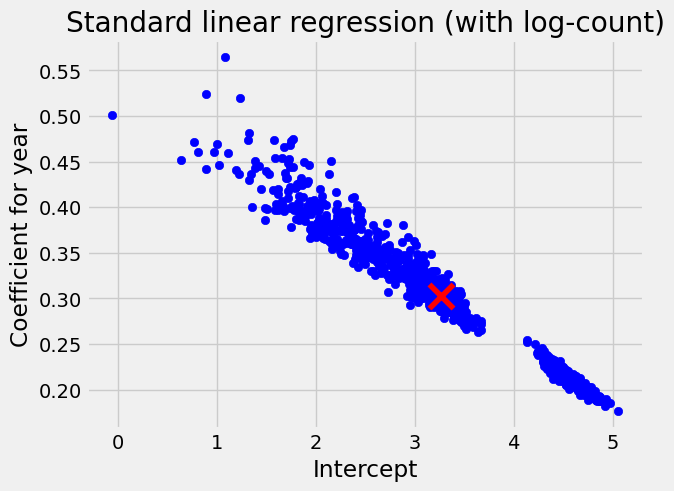

In [27]:
w_gaussian_boot = bootstrap_xy(sm.add_constant(ok_turbines.year), ok_turbines.log_totals, lin_model)
plt.xlabel('Intercept')
plt.ylabel('Coefficient for year')
plt.title('Standard linear regression (with log-count)')

In [28]:
w_gaussian_boot

array([[4.42639504, 0.21746565],
       [4.32209844, 0.23793026],
       [1.79787472, 0.4223173 ],
       ...,
       [4.55593011, 0.21184422],
       [1.9570472 , 0.37161612],
       [4.74168576, 0.19767019]])

In [29]:
beta_0, beta_1 = w_gaussian_boot.std(axis = 0)
print(f"Bootstrap std error for intercept: {beta_0:.3f}")
print(f"Bootstrap std error for year coeff: {beta_1:.3f}")

Bootstrap std error for intercept: 1.033
Bootstrap std error for year coeff: 0.075


In [30]:
gaussian_model = sm.GLM(
    ok_turbines.log_totals, sm.add_constant(ok_turbines.year), 
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             log_totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1810
Method:                          IRLS   Log-Likelihood:                -24.472
Date:                Tue, 15 Oct 2024   Deviance:                       17.716
Time:                        13:33:12   Pearson chi2:                     17.7
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9131
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2602      0.590      5.526      0.0

Text(0.5, 1.0, 'Poisson regression')

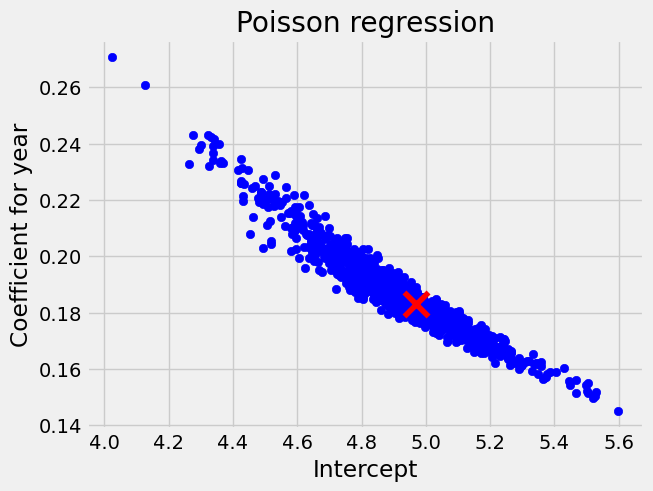

In [31]:
w_poisson_boot = bootstrap_xy(sm.add_constant(ok_turbines.year), ok_turbines.totals, poisson_model)

plt.xlabel('Intercept')
plt.ylabel('Coefficient for year')
plt.title('Poisson regression')

In [32]:
beta_0, beta_1 = w_poisson_boot.std(axis = 0)
print(f"Bootstrap std error for intercept: {beta_0:.3f}")
print(f"Bootstrap std error for year: {beta_1:.3f}")

Bootstrap std error for intercept: 0.219
Bootstrap std error for year: 0.016


In [33]:
poisson_model = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.Poisson()
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -755.42
Date:                Tue, 15 Oct 2024   Deviance:                       1366.3
Time:                        13:33:13   Pearson chi2:                 1.20e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9697      0.023    219.386      0.0

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.w

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.w

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.w

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.w

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.w

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.w

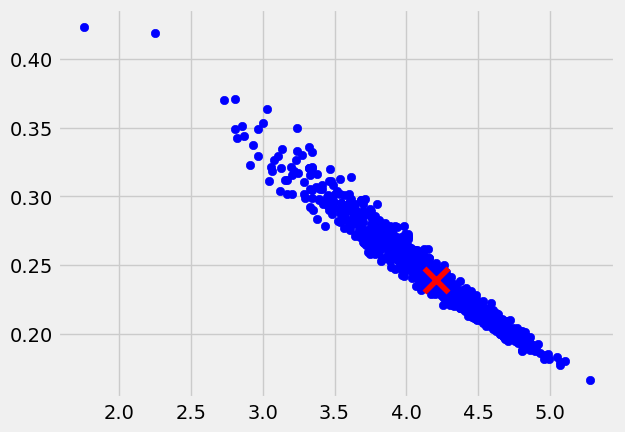

In [34]:
w_negbin_boot = bootstrap_xy(sm.add_constant(ok_turbines.year), ok_turbines.totals, negbin_model)

In [35]:
beta_0, beta_1 = w_negbin_boot.std(axis = 0)
print(f"Bootstrap std error for const: {beta_0:.3f}")
print(f"Bootstrap std error for year: {beta_1:.3f}")

Bootstrap std error for const: 0.436
Bootstrap std error for year: 0.035


In [36]:
negbin_model = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model.fit()
print(negbin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.14
Date:                Tue, 15 Oct 2024   Deviance:                       7.1483
Time:                        13:33:14   Pearson chi2:                     1.90
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6999
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2059      0.544      7.725      0.0

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
